## Backtest Orchestrator Workflow

This notebook automates a rolling-window backtest by iteratively executing a worker notebook (`py11_worker_sharpe_strategy.ipynb`) for each time slice.

**Workflow:**

1.  **Setup:** Loads project configurations and strategy parameters.
2.  **Load Data:** Reads the master adjusted close prices file.
3.  **Prepare Data Chunks:** Creates rolling window data chunks for the entire dataset.
4.  **Split Data:** Divides the chunks into an **In-Sample** set (for the main walk-forward backtest) and a **Holdout** set (for final, unseen data verification).
5.  **Execute In-Sample Backtests:** Loops through the **In-Sample** chunks, running the worker notebook for each one.
6.  **Aggregate In-Sample Results:** Collects and combines the results from the in-sample backtest into a single portfolio returns file.
7.  **Cleanup:** Deletes temporary data files.
8.  **Next Steps:** Outlines how to use the **Holdout** data for a final, true out-of-sample validation.

## Step 1: Setup and Configuration

This cell contains all imports and configuration variables. It defines the project structure and parameters for the rolling backtest.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import papermill as pm
import shutil
from IPython.display import display, Markdown

# --- Project Path Configuration ---
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent
DATA_DIR = ROOT_DIR / 'data'
SRC_DIR = ROOT_DIR / 'src'
TEMP_DIR = NOTEBOOK_DIR / 'temp_backtest_data'
OUTPUT_DIR = NOTEBOOK_DIR / 'backtest_results'

# --- Add src to Python path ---
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# --- Import Custom Modules ---
import utils

# --- Papermill Configuration ---
WORKER_NOTEBOOK_NAME = "_pm_worker_sharpe_strategy.ipynb"
WORKER_NOTEBOOK_PATH = NOTEBOOK_DIR / WORKER_NOTEBOOK_NAME
IN_SAMPLE_RESULTS_FILENAME = "underperformers_returns.parquet"
# [NEW] A separate filename for the eventual holdout results
HOLDOUT_RESULTS_FILENAME = "holdout_portfolio_returns.parquet"

# --- Strategy & Backtest Parameters ---
SLIDING_WINDOW_WIDTH = 300
SLIDING_WINDOW_STEP = 30
TRAIN_TEST_SPLIT_POINT = 270
BENCHMARK_TICKER = 'VGT'
FINVIZ_DATA_FILENAME = '2025-08-01_df_finviz_merged_stocks_etfs.parquet'
# [NEW] Ratio of chunks to reserve for the final holdout test. 0.25 means the last 25% of chunks are held out.
HOLDOUT_SPLIT_RATIO = 0.25
BACKTEST_CHUNK_LIMIT = 2

# --- Verification ---
print("--- Path Configuration ---")
print(f"ROOT_DIR:                {ROOT_DIR}")
print(f"NOTEBOOK_DIR:            {NOTEBOOK_DIR}")
print(f"DATA_DIR:                {DATA_DIR}")
print(f"SRC_DIR:                 {SRC_DIR}")
print(f"TEMP_DIR:                {TEMP_DIR}")
print(f"OUTPUT_DIR:              {OUTPUT_DIR}")
print(f"WORKER_NOTEBOOK_PATH:    {WORKER_NOTEBOOK_PATH}")
assert all([ROOT_DIR.exists(), DATA_DIR.exists(), SRC_DIR.exists(), NOTEBOOK_DIR.exists()]), "A key directory was not found!"
assert (DATA_DIR / FINVIZ_DATA_FILENAME).exists(), f"Finviz data file not found: {FINVIZ_DATA_FILENAME}"
assert WORKER_NOTEBOOK_PATH.exists(), f"Worker notebook not found at: {WORKER_NOTEBOOK_PATH}"

print("\n--- Strategy Parameters ---")
print(f"Window Width:  {SLIDING_WINDOW_WIDTH}, Step Size: {SLIDING_WINDOW_STEP}")
print(f"In-Sample/Holdout Split Ratio: {HOLDOUT_SPLIT_RATIO}")
print(f"Train/Test Split: {TRAIN_TEST_SPLIT_POINT} rows for training")
print(f"Benchmark:     {BENCHMARK_TICKER}")
if BACKTEST_CHUNK_LIMIT is None:
    print(f"Chunk Limit:   None (run all in-sample chunks)")
else:
    print(f"Chunk Limit:   {BACKTEST_CHUNK_LIMIT} (for testing)")

--- Path Configuration ---
ROOT_DIR:                c:\Users\ping\Files_win10\python\py311\stocks
NOTEBOOK_DIR:            c:\Users\ping\Files_win10\python\py311\stocks\colab
DATA_DIR:                c:\Users\ping\Files_win10\python\py311\stocks\data
SRC_DIR:                 c:\Users\ping\Files_win10\python\py311\stocks\src
TEMP_DIR:                c:\Users\ping\Files_win10\python\py311\stocks\colab\temp_backtest_data
OUTPUT_DIR:              c:\Users\ping\Files_win10\python\py311\stocks\colab\backtest_results
WORKER_NOTEBOOK_PATH:    c:\Users\ping\Files_win10\python\py311\stocks\colab\_pm_worker_sharpe_strategy.ipynb

--- Strategy Parameters ---
Window Width:  300, Step Size: 30
In-Sample/Holdout Split Ratio: 0.25
Train/Test Split: 270 rows for training
Benchmark:     VGT
Chunk Limit:   2 (for testing)


In [2]:
overperformers_returns_file_path = OUTPUT_DIR / 'sharpe_all_overperformers.parquet'
# output_notebook_chunk_0_path = OUTPUT_DIR / 'output_notebook_chunk_0.parquet'
# result_chunk_0_path = OUTPUT_DIR / 'result_chunk_0.parquet'

In [3]:
overperformers_returns = pd.read_parquet(overperformers_returns_file_path)
overperformers_returns

,Portfolio,Benchmark
Date,,
2016-02-01,0.002070,0.002452
2016-02-02,-0.008647,-0.020258
2016-02-03,0.002134,-0.002297
2016-02-04,-0.001427,0.002403
2016-02-05,-0.014309,-0.037456
...,...,...
2023-02-03,-0.008202,-0.010604
2023-02-06,-0.005860,-0.013121
2023-02-07,0.007120,0.023962


In [4]:
# Calculate the cumulative returns for the portfolio and 'VGT'
overperformers_returns['Portfolio_Cumulative'] = (1 + overperformers_returns['Portfolio']).cumprod()
overperformers_returns['VGT_Cumulative'] = (1 + overperformers_returns['Benchmark']).cumprod()

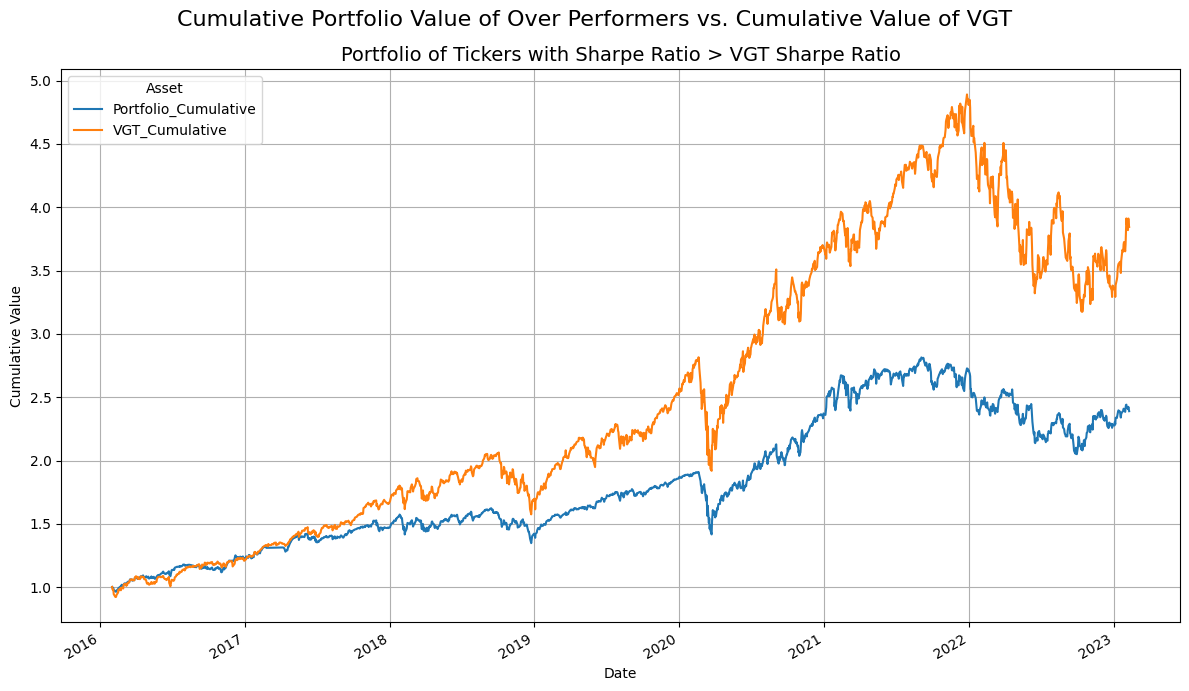

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 2. Plotting Cumulative Values ---

plt.figure(figsize=(12, 7))
overperformers_returns[['Portfolio_Cumulative', 'VGT_Cumulative']].plot(ax=plt.gca()) # Plot directly from DataFrame


plt.suptitle('Cumulative Portfolio Value of Over Performers vs. Cumulative Value of VGT', fontsize=16,) # Super Title
plt.title('Portfolio of Tickers with Sharpe Ratio > VGT Sharpe Ratio', fontsize=14)


plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend(title='Asset')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [6]:
underperformers_returns_file_path = OUTPUT_DIR / 'sharpe_all_underperformers.parquet'
# output_notebook_chunk_0_path = OUTPUT_DIR / 'output_notebook_chunk_0.parquet'
# result_chunk_0_path = OUTPUT_DIR / 'result_chunk_0.parquet'

In [7]:
underperformers_returns = pd.read_parquet(underperformers_returns_file_path)
underperformers_returns

,Portfolio,Benchmark
Date,,
2016-02-01,-0.002424,0.002452
2016-02-02,-0.030635,-0.020258
2016-02-03,0.006587,-0.002297
2016-02-04,0.013952,0.002403
2016-02-05,-0.020988,-0.037456
...,...,...
2023-02-03,-0.025236,-0.010604
2023-02-06,-0.016189,-0.013121
2023-02-07,0.013473,0.023962


In [8]:
# Calculate the cumulative returns for the portfolio and 'VGT'
underperformers_returns['Portfolio_Cumulative'] = (1 + underperformers_returns['Portfolio']).cumprod()
underperformers_returns['VGT_Cumulative'] = (1 + underperformers_returns['Benchmark']).cumprod()

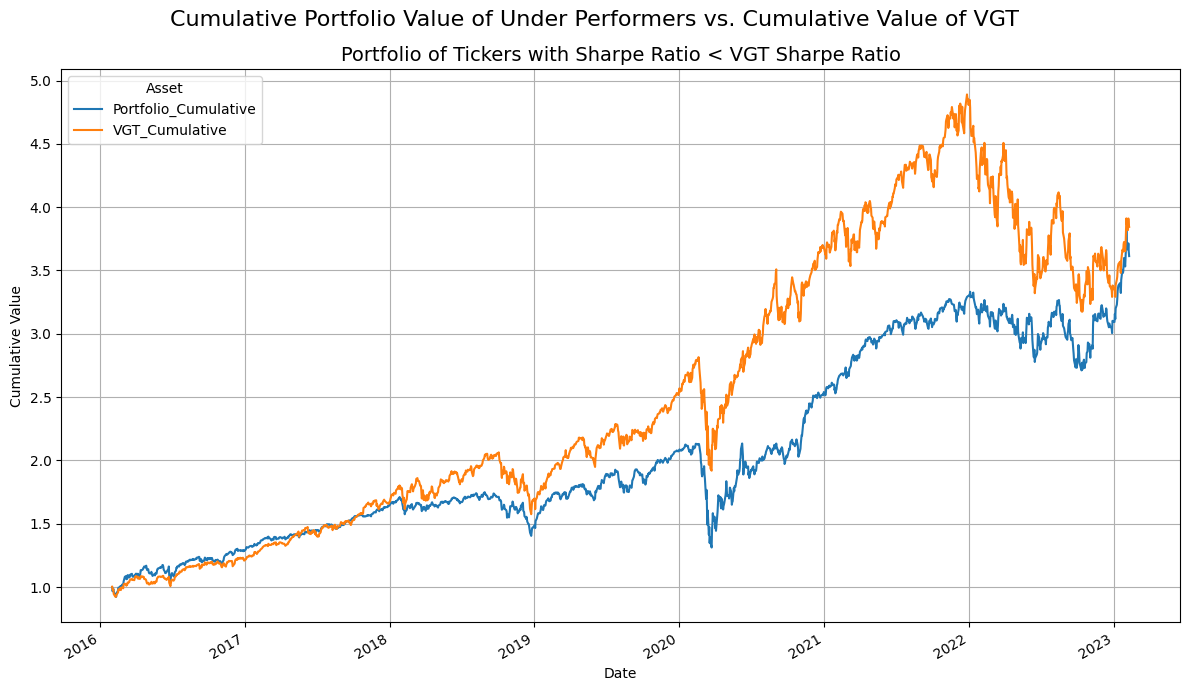

In [9]:
underperformers_returns_file_path = OUTPUT_DIR / 'sharpe_all_underperformers.parquet'
# output_notebook_chunk_0_path = OUTPUT_DIR / 'output_notebook_chunk_0.parquet'
# result_chunk_0_path = OUTPUT_DIR / 'result_chunk_0.parquet'
underperformers_returns = pd.read_parquet(underperformers_returns_file_path)
underperformers_returns
# Calculate the cumulative returns for the portfolio and 'VGT'
underperformers_returns['Portfolio_Cumulative'] = (1 + underperformers_returns['Portfolio']).cumprod()
underperformers_returns['VGT_Cumulative'] = (1 + underperformers_returns['Benchmark']).cumprod()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 2. Plotting Cumulative Values ---

plt.figure(figsize=(12, 7))
underperformers_returns[['Portfolio_Cumulative', 'VGT_Cumulative']].plot(ax=plt.gca()) # Plot directly from DataFrame


plt.suptitle('Cumulative Portfolio Value of Under Performers vs. Cumulative Value of VGT', fontsize=16,) # Super Title
plt.title('Portfolio of Tickers with Sharpe Ratio < VGT Sharpe Ratio', fontsize=14)


plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend(title='Asset')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()